# Plan of Action

In [1]:
import matplotlib.pyplot as plt
import os

import pandas

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
from common_utils import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(69)
tf.random.set_seed(69)

## Import Dataset

In [2]:

image_paths_csv = pd.read_csv("./processed_data/image_paths.csv")
paths_train_df, paths_val_df, paths_test_df = split_data(image_paths_csv)


## Organize Dataset

In [3]:

paths_train_df_list = list(paths_train_df['path'])
paths_train_labels_list = list(paths_train_df['age_bin'])


paths_val_df_list = list(paths_val_df['path'])
paths_val_labels_list = list(paths_val_df['age_bin'])


paths_test_df_list = list(paths_test_df['path'])
paths_test_labels_list = list(paths_test_df['age_bin'])


In [13]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(paths_train_df_list)
train_labels_tensor = tf.constant(paths_train_labels_list)

val_filenames_tensor = tf.constant(paths_val_df_list)
val_labels_tensor = tf.constant(paths_val_labels_list)

test_filenames_tensor = tf.constant(paths_test_df_list)
test_labels_tensor = tf.constant(paths_test_labels_list)


# Image Greyscale Function

# CNN Architecture

In [14]:
configs = [
    {"name": "baseline"},
    
    {"name": "A1_relu_k3", "activation": "relu", "kernel_size": 3},
    {"name": "A2_tanh_k3", "activation": "tanh", "kernel_size": 3},
    {"name": "A3_relu_k5", "activation": "relu", "kernel_size": 5},
    {"name": "A4_selu_k7", "activation": "selu", "kernel_size": 7},
    
    {"name": "B1_shallow", "conv_filters": [32, 64]},
    {"name": "B2_deep", "conv_filters": [32, 64, 128, 256, 512]},
    
    {"name": "J1_dense_512", "dense_units": [512]},
    {"name": "J2_dense_256_128", "dense_units": [256, 128]},
    
    {"name": "E1_dense1", "dense_units": [128]},
    {"name": "E2_dense3", "dense_units": [256, 128, 64]},
    
      # Grayscale (1-channel) input
    {"name": "F1_gray", "channels": 1},
    {"name": "F2_gray_k5", "channels": 1, "kernel_size": 5},
    {"name": "F3_gray_deep", "channels": 1, "conv_filters": [32, 64, 128, 256]},
    {"name": "F4_gray_dense2", "channels": 1, "dense_units": [256, 128]},

    
    {"name": "H1_dropout_0.3", "dropout_rate": 0.3},
    {"name": "H2_dropout_0.7", "dropout_rate": 0.7},
    
        # Batch size variations
    {"name": "B3_batch_128", "batch_size": 128},
    {"name": "B4_batch_64", "batch_size": 64},
    
        # Epoch variations
    {"name": "E1_epochs_60", "epochs": 60},
    {"name": "E2_epochs_180", "epochs": 180},
    {"name": "E3_epochs_240", "epochs": 240},
    {"name": "E4_epochs_300", "epochs": 300},
    
    {"name": "I1_deep_selu", "activation": "selu", "conv_filters": [64, 128, 256, 512]},
    {"name": "I2_shallow_tanh", "activation": "tanh", "conv_filters": [16, 32]},

    {"name": "K1_k7_deep", "kernel_size": 7, "conv_filters": [64, 128, 256]}
]
default_args = {
    "batch_size": 256,
    "epochs": 120,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "classification",
    "num_classes": 13,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax"
}


ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    cfg_full = {**default_args, **cfg}
    
    train_dataset = load_images_from_paths(train_filenames_tensor, train_labels_tensor, 
                                           channels=cfg_full["channels"],
                                           ratio=ratio,
                                           batch_size=cfg_full['batch_size'],
                                           class_count=cfg_full['num_classes'])
    
    val_dataset = load_images_from_paths(val_filenames_tensor,val_labels_tensor,
                                         channels=cfg_full["channels"],
                                         ratio=ratio,
                                         batch_size=cfg_full['batch_size'],
                                         class_count=cfg_full['num_classes'])
    test_dataset = load_images_from_paths(test_filenames_tensor,test_labels_tensor,
                                         channels=cfg_full["channels"],
                                         ratio=ratio,
                                         batch_size=cfg_full['batch_size'],
                                         class_count=cfg_full['num_classes'])
    
    model = build_sequential_cnn_model(
        channels=cfg_full["channels"],
        dropout_rate=cfg_full["dropout_rate"],
        task=cfg_full["task"],
        num_classes=cfg_full["num_classes"],
        conv_filters=cfg_full["conv_filters"],
        kernel_size=cfg_full["kernel_size"],
        activation=cfg_full["activation"],
        dense_units=cfg_full["dense_units"],
        output_activation=cfg_full["output_activation"]
    )
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cfg_full["model"] = model
    cfg_full["train_data"]=train_dataset
    cfg_full["val_data"]=val_dataset
    cfg_full["test_data"]=test_dataset
    
    model_list.append(cfg_full)

df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} 
    for entry in model_list
])



# Model Fitting

In [16]:
os.makedirs("saved_models", exist_ok=True)


for entry in model_list:
    model_name = entry["name"]
    
    # Setup model checkpoint callback
    checkpoint_path = f"saved_models/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    
    # Train model
    history = entry['model'].fit(
        entry['train_data'],
        validation_data=entry['val_data'],
        epochs=entry['epochs'],
        batch_size=entry['batch_size'],
        verbose=2,
        callbacks=[checkpoint]
    )

    # Save training history in entry
    entry['history'] = history.history
    entry['best_model_path'] = checkpoint_path

    
model_list.to
    

Epoch 1/120

Epoch 1: val_accuracy improved from -inf to 0.16058, saving model to saved_models/baseline_best_model.keras
3/3 - 2s - 770ms/step - accuracy: 0.1543 - loss: 2.4647 - val_accuracy: 0.1606 - val_loss: 2.3905
Epoch 2/120

Epoch 2: val_accuracy did not improve from 0.16058
3/3 - 2s - 559ms/step - accuracy: 0.1724 - loss: 2.4692 - val_accuracy: 0.1606 - val_loss: 2.3818
Epoch 3/120

Epoch 3: val_accuracy improved from 0.16058 to 0.18248, saving model to saved_models/baseline_best_model.keras
3/3 - 2s - 549ms/step - accuracy: 0.1615 - loss: 2.4600 - val_accuracy: 0.1825 - val_loss: 2.3723
Epoch 4/120

Epoch 4: val_accuracy did not improve from 0.18248
3/3 - 2s - 534ms/step - accuracy: 0.1833 - loss: 2.4471 - val_accuracy: 0.1825 - val_loss: 2.3545
Epoch 5/120

Epoch 5: val_accuracy improved from 0.18248 to 0.21168, saving model to saved_models/baseline_best_model.keras
3/3 - 2s - 816ms/step - accuracy: 0.1833 - loss: 2.4724 - val_accuracy: 0.2117 - val_loss: 2.3332
Epoch 6/120



KeyboardInterrupt: 

# Checking Model Performance

KeyError: 'history'

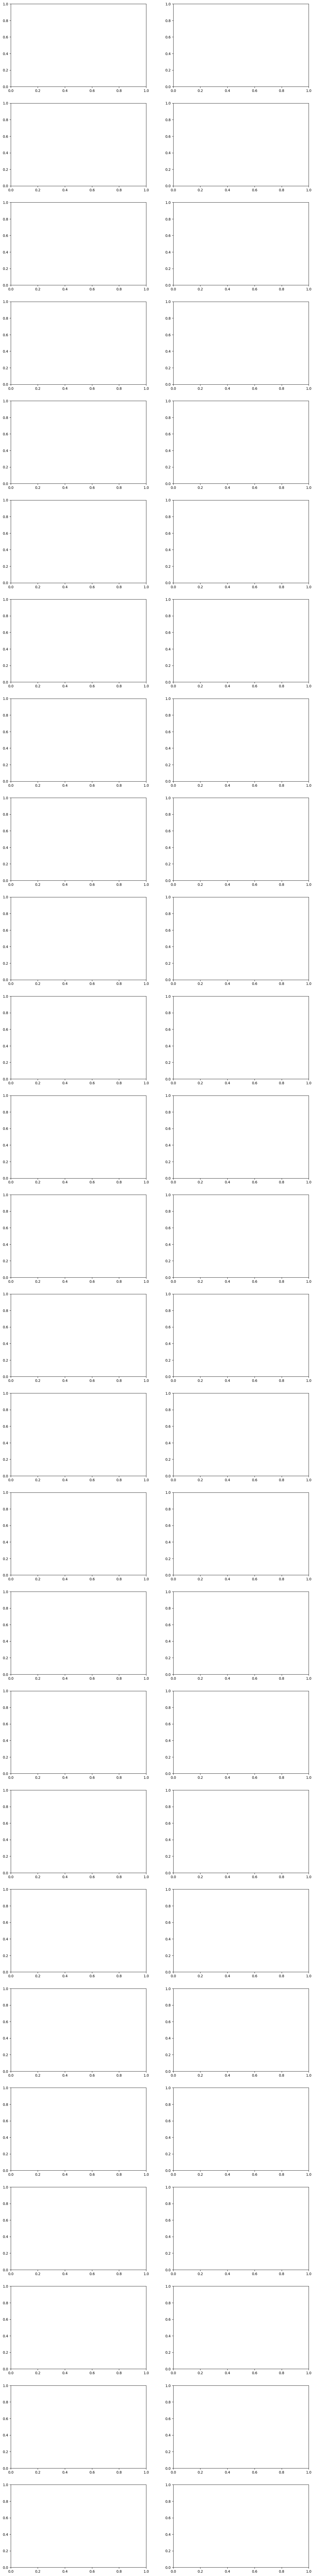

In [17]:

# Create subplots: one row per model, two columns (loss and accuracy)
fig, axes = plt.subplots(nrows=len(model_list), ncols=2, figsize=(15, 5 * len(model_list)))

# Ensure axes is always 2D
if len(model_list) == 1:
    axes = np.array([axes])

# Loop through each trained model entry
for i, entry in enumerate(model_list):
    model_name = entry["name"]
    history = entry["history"]

    epochs = list(range(1, len(history["loss"]) + 1))

    # Loss Plot
    ax_loss = axes[i, 0]
    ax_loss.plot(epochs, history["loss"], label='Train Loss', marker='o')
    ax_loss.plot(epochs, history["val_loss"], label='Val Loss', marker='o')
    ax_loss.set_title(f"{model_name} - Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()

    # Accuracy Plot
    ax_acc = axes[i, 1]
    ax_acc.plot(epochs, history["accuracy"], label='Train Accuracy', marker='o')
    ax_acc.plot(epochs, history["val_accuracy"], label='Val Accuracy', marker='o')
    ax_acc.set_title(f"{model_name} - Accuracy")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()

plt.tight_layout()
plt.show()

In [74]:


# Loop through each trained model entry
for i, entry in enumerate(model_list):
    model_name = entry["name"]
    best_model_path = entry["best_model_path"]
    test_dataset = entry['test_data']
    # Load the best saved model
    model = load_model(best_model_path)

    # Evaluate on test set
    model_score = model.evaluate(test_dataset, verbose=1)
    model_labels = model.metrics_names

    print(f"🔍 {model_name} — Evaluation on Test Set:")
    for label, score in zip(model_labels, model_score):
        print(f"   {label}: {round(score, 4)}")
    print("-" * 40)


model_entry Model_1
model_object 116    <Sequential name=sequential_3, built=True>
Name: model_object, dtype: object
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3906 - loss: 1.7583

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3914 - loss: 1.7591 
Func model loss 	= 1.76
Func model compile_metrics 	= 0.392
model_entry Model_2
model_object 238    <Sequential name=sequential_2, built=True>
Name: model_object, dtype: object
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4126 - loss: 1.8309 
Func model loss 	= 1.823
Func model compile_metrics 	= 0.414


### Plotting Confusion Matrix

In [75]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'./output/{export_as}.png', bbox_inches='tight')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step
Normalized confusion matrix


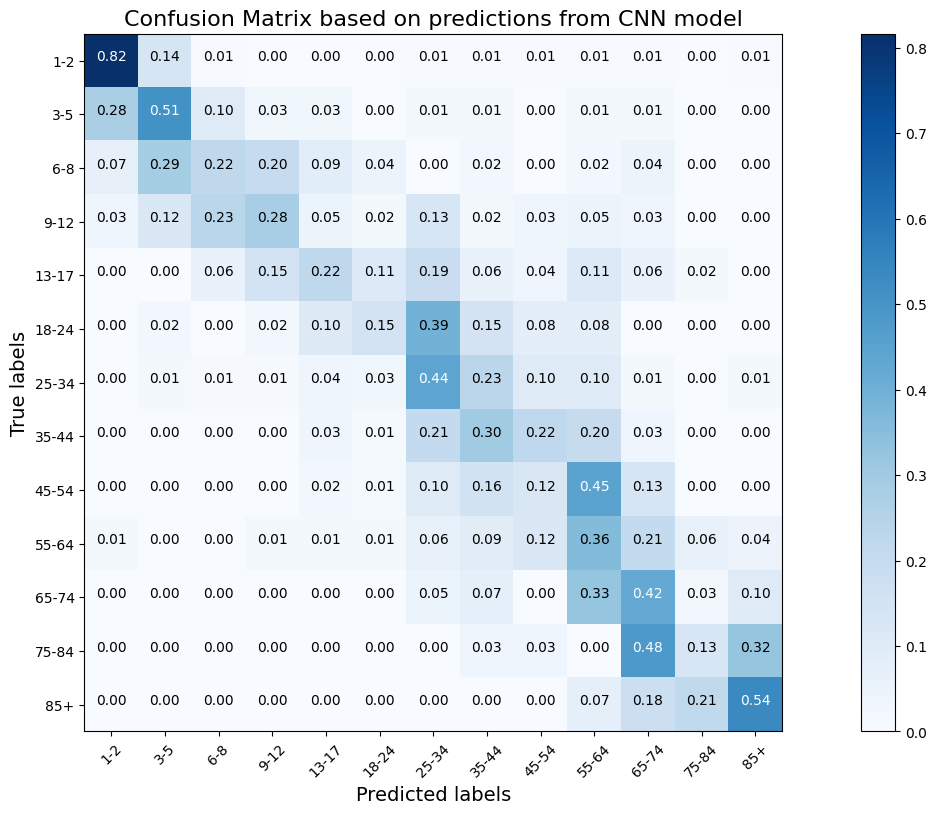

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 743ms/step
Normalized confusion matrix


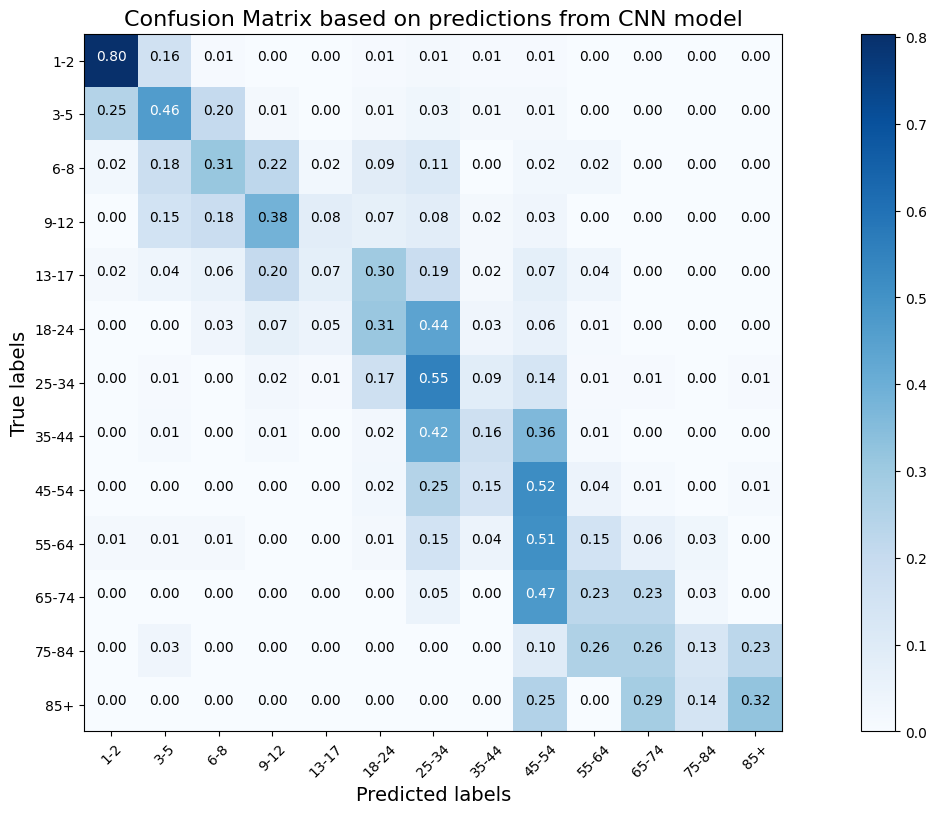

In [ ]:

# Define class labels
cm_plot_labels = ['1-2', '3-5', '6-8', '9-12', '13-17', '18-24', '25-34', 
                  '35-44', '45-54', '55-64', '65-74', '75-84', '85+']

# Loop through all models
for i, entry in enumerate(model_list):
    model_name = entry["name"]
    best_model_path = entry["best_model_path"]
    test_dataset = entry['test_data']

    print(f"🔍 Evaluating Confusion Matrix for: {model_name}")

    # Load the best saved model
    model = load_model(best_model_path)

    # Predict class probabilities
    model_pred_probs = model.predict(test_dataset)
    model_pred = model_pred_probs.argmax(axis=-1)

    # Ground truth (assuming it's a flat list of class indices)
    y_true = paths_test_labels_list

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_true, model_pred)

    # Plot confusion matrix
    plt.figure(figsize=(16, 8))
    plot_confusion_matrix(
        conf_mat,
        cm_plot_labels,
        normalize=True,
        title=f"Confusion Matrix - {model_name}",
        export_as=None  # Change to f"{model_name}_confmat" to save
    )
    plt.show()